# Description

In the previous notebook, we found that LV603 gene weight's are predictive of gene associations for basophil percentage.
In a real application, you would run the `gls_cli.py` tool for your trait of interest across all LVs in our models, and get the significant ones. Then you can see in which cell types the LVs' genes are expressed, and this is what we are going to do in this notebook for LV603.

To find the cell types associated with an LV, we'll use matrix **B** (see the figure b) below and our [manuscript](https://greenelab.github.io/phenoplier_manuscript/#phenoplier-an-integration-framework-based-on-gene-co-expression-patterns)).
We can link RNA-seq samples in matrix B with gene expression metadata and explore which cell types are associated with the LV.
However, metadata in gene expression datasets is usually hard to read, process and interpret, and many times important attributes (such as `tissue` or `cell type`) are missing.
We provide some tools to try to overcome this problem, and it is shown below.

![](https://greenelab.github.io/phenoplier_manuscript/images/entire_process/entire_process.svg)

# Modules

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath("/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/T1D-phenoplier/libs"))
os.environ["PHENOPLIER_ROOT_DIR"] = "/pl/active/pivlab/projects/srajery/data/phenoplier"

import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

Specify below the LV id you are interested in:

In [2]:
LV_NAME = "LV54"

# Paths

These are paths to folder and files where we'll save our figures.

In [3]:
OUTPUT_FIGURES_DIR = Path(conf.RESULTS_DIR, "demo", f"{LV_NAME.lower()}").resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/pl/active/pivlab/projects/srajery/data/phenoplier/results/demo/lv54')

In [4]:
OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
display(OUTPUT_CELL_TYPE_FILEPATH)

PosixPath('/pl/active/pivlab/projects/srajery/data/phenoplier/results/demo/lv54/lv54-cell_types.svg')

# Load MultiPLIER summary

In [5]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [6]:
multiplier_model_summary.shape

(2157, 5)

In [7]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load LV data

You can use the `LVAnalysis` class to explore an LV.

In [11]:
lv_obj = LVAnalysis(LV_NAME)

Here I show the top 20 genes for our LV. You can see gene symbols, the LV weight (in column `LV603`) and the cytoband.

In [12]:
lv_obj.lv_genes.head(20)

,gene_name,LV54,gene_band
0,CYP21A2,5.645587,6p21.33
1,TNXB,3.637999,6p21.32
2,EXOSC7,3.631415,3p21.31
3,CFD,3.356875,19p13.3
4,IGFBP6,2.336614,12q13.13
5,JDP2,2.167463,14q24.3
6,CD248,1.932278,11q13.2
7,CCL14,1.791890,17q12
8,NDUFA4L2,1.692841,12q13.3
9,LCAT,1.620212,16q22.1


Show the pathways our LV is aligned to (neutrophils):

In [13]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        & (multiplier_model_summary["AUC"] >= 0.75)
    )
]

,pathway,LV index,AUC,p-value,FDR


Here I load the LV metadata.
This is, for each sample from our matrix B, we load its metadata.
The `LVAnalysis` class takes care of downloading all necessary files from recount2.

In [14]:
lv_data = lv_obj.get_experiments_data()

SRP017575, SRP006575, SRP036821, SRP008218, SRP019994, SRP023262, SRP010038, SRP004965, SRP040292, SRP052706, SRP060416, SRP051249, SRP055569, SRP042620, SRP066834, SRP036053, SRP000599, SRP018359, SRP014146, SRP043162, SRP039338, SRP035988, SRP055749, SRP042086, SRP007359, SRP053101, SRP045154, SRP041538, SRP055512, SRP060355, SRP030617, SRP012656, SRP011924, SRP052978, SRP042161, SRP053190, SRP033135, SRP052991, SRP063838, SRP061888, SRP021478, SRP029899, SRP050971, SRP058773, SRP041718, SRP064464, SRP014739, SRP003726, SRP043166, SRP053098, SRP057196, SRP021193, 

In [15]:
lv_data.shape

(5736, 70)

In [16]:
lv_data.head()

tissue tissue archive method    stromal signature  \
project   run                                                                 
SRP017575 SRR633556  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633557  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633558  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633559  Soft Tissue                  FFPE  DTF(3SEQ) signature   
          SRR633560  Soft Tissue                  FFPE  DTF(3SEQ) signature   

                    prognosis cell line cell type developmental stage  \
project   run                                                           
SRP017575 SRR633556   UNCLEAR       NaN       NaN                 NaN   
          SRR633557   UNCLEAR       NaN       NaN                 NaN   
          SRR633558   UNCLEAR       NaN       NaN                 NaN   
          SRR633559   UNCLEAR       NaN       NaN                 NaN   
          SRR633560   UNCLEAR       NaN       NaN                 NaN   

                    disease status tissue subtype source  ...  \
project   run                                             ...   
SRP017575 SRR633556            NaN            NaN    NaN  ...   
          SRR633557            NaN            NaN    NaN  ...   
          SRR633558            NaN            NaN    NaN  ...   
          SRR633559            NaN            NaN    NaN  ...   
          SRR633560            NaN            NaN    NaN  ...   

                    assigned cell type qc pass cell count ercc_dilution  \
project   run                                                             
SRP017575 SRR633556                NaN     NaN        NaN           NaN   
          SRR633557                NaN     NaN        NaN           NaN   
          SRR633558                NaN     NaN        NaN           NaN   
          SRR633559                NaN     NaN        NaN           NaN   
          SRR633560                NaN     NaN        NaN           NaN   

                    patient condition race c1 chip id experiment_sample_name  \
project   run                                                                  
SRP017575 SRR633556               NaN  NaN        NaN                    NaN   
          SRR633557               NaN  NaN        NaN                    NaN   
          SRR633558               NaN  NaN        NaN                    NaN   
          SRR633559               NaN  NaN        NaN                    NaN   
          SRR633560               NaN  NaN        NaN                    NaN   

                    lvad support      LV54  
project   run                               
SRP017575 SRR633556          NaN  0.175936  
          SRR633557          NaN  0.210196  
          SRR633558          NaN  0.433927  
          SRR633559          NaN  0.298636  
          SRR633560          NaN  0.209013  

[5 rows x 70 columns]

# LV cell types analysis

## Get top attributes

Here I quickly show the top attributes in our metadata for which we have the largest LV variance.
This is just to have an idea of the variance across different attributes

In [17]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/phenoplier/libs/data/recount2.py:374: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  _tmp = getattr(_tmp, func)()
/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/phenoplier/libs/data/recount2.py:374: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  _tmp = getattr(_tmp, func)()
/pl/active/pivlab/projects/srajery/repositories/T1D_LV_analysis/phenoplier/libs/data/recount2.py:374: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. I

stromal signature        0.258559
prognosis                0.258559
tissue subtype           0.192408
antibody catalog #       0.186369
antibody vender          0.186369
parity                   0.165466
source                   0.150730
tissue archive method    0.143057
cell marker              0.058868
patient                  0.041685
developmental stage      0.038682
disease status           0.038682
passages                 0.037933
subtypes                 0.031722
tissue id                0.028897
patient number           0.028897
tissue                   0.024750
treatment                0.024434
age in weeks             0.016083
disease state            0.011949
dtype: float64

Since we are interested in cell types and tissues, the code below will find which attributes contain "cell type" or "tissue", so we can select from these results.

In [18]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.*(type|line)$)|(?:tissue$)|(?:tissue.*type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

tissue subtype    0.192408
tissue            0.024750
cell type         0.004538
tissue type       0.002226
cell line         0.000979
dtype: float64

Select from the output above those you are interested in. Usually all of them.

In [19]:
lv_attrs_selected = [
    "tissue subtype",
    "tissue",
    "cell type",
    "tissue type",
    "cell line"
]

In [20]:
_tmp = lv_data.loc[
    :,
    lv_attrs_selected + [LV_NAME],
]

In [21]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

Now that we selected attributes that might be providing information about the cell type, we can see which are the top ones.

If you change the number in the cell below, you can paginate over the entire set of results; for example, with `_tmp_seq[1]` you'll see the next "page" in a descending order with respect to the LV value. So the ones at the top are the most important ones.

In [22]:
_tmp_seq[0]

tissue subtype                        tissue  \
project   run                                                       
SRP017575 SRR633580             NaN                   Soft Tissue   
SRP006575 SRR191718             NaN  dedifferentiated liposarcoma   
SRP036821 SRR1163261          DDLPS           soft tissue sarcoma   
SRP017575 SRR633579             NaN                   Soft Tissue   
          SRR633581             NaN                   Soft Tissue   
SRP008218 SRR343344             NaN                        breast   
SRP017575 SRR633594             NaN                   Soft Tissue   
          SRR633578             NaN                   Soft Tissue   
SRP019994 SRR797093             NaN                   Soft Tissue   
SRP017575 SRR633586             NaN                   Soft Tissue   
          SRR633588             NaN                   Soft Tissue   
SRP006575 SRR191716             NaN  dedifferentiated liposarcoma   
SRP036821 SRR1163262          DDLPS           soft tissue sarcoma   
SRP017575 SRR633567             NaN                   Soft Tissue   
SRP006575 SRR191695             NaN            myxoid liposarcoma   
          SRR191696             NaN            myxoid liposarcoma   
SRP023262 SRR868869             NaN                        breast   
SRP036821 SRR1163245        GIST WT           soft tissue sarcoma   
SRP017575 SRR633574             NaN                   Soft Tissue   
SRP010038 SRR392874             NaN                           NaN   
SRP004965 SRR088864             NaN                        breast   
          SRR088863             NaN                        breast   
SRP010038 SRR392898             NaN                           NaN   
          SRR392873             NaN                           NaN   
SRP006575 SRR537108             NaN                          lung   

                                        cell type tissue type cell line  \
project   run                                                             
SRP017575 SRR633580                           NaN         NaN       NaN   
SRP006575 SRR191718                           NaN         NaN       NaN   
SRP036821 SRR1163261                          NaN         NaN       NaN   
SRP017575 SRR633579                           NaN         NaN       NaN   
          SRR633581                           NaN         NaN       NaN   
SRP008218 SRR343344   bead purified stromal cells         NaN       NaN   
SRP017575 SRR633594                           NaN         NaN       NaN   
          SRR633578                           NaN         NaN       NaN   
SRP019994 SRR797093                           NaN         NaN       NaN   
SRP017575 SRR633586                           NaN         NaN       NaN   
          SRR633588                           NaN         NaN       NaN   
SRP006575 SRR191716                           NaN         NaN       NaN   
SRP036821 SRR1163262                          NaN         NaN       NaN   
SRP017575 SRR633567                           NaN         NaN       NaN   
SRP006575 SRR191695                           NaN         NaN       NaN   
          SRR191696                           NaN         NaN       NaN   
SRP023262 SRR868869                           NaN         NaN       NaN   
SRP036821 SRR1163245                          NaN         NaN       NaN   
SRP017575 SRR633574                           NaN         NaN       NaN   
SRP010038 SRR392874                Pterygia cells         NaN       NaN   
SRP004965 SRR088864               epithelial cell         NaN       NaN   
          SRR088863               epithelial cell         NaN       NaN   
SRP010038 SRR392898                Pterygia cells         NaN       NaN   
          SRR392873                Pterygia cells         NaN       NaN   
SRP006575 SRR537108                           NaN         NaN       NaN   

                          LV54  
project   run                   
SRP017575 SRR633580   2.781848  
SRP006575 SRR191718   2.532321  

You can see above that the RNA-seq samples are from neutrophils or granulocytes.
If we move to the next "page", we'll see this:

In [23]:
_tmp_seq[1]

tissue subtype               tissue  \
project   run                                              
SRP010038 SRR392881             NaN                  NaN   
SRP008218 SRR343345             NaN               breast   
SRP040292 SRR1199126            NaN        adrenal tumor   
SRP023262 SRR868868             NaN               breast   
SRP010038 SRR392897             NaN                  NaN   
          SRR392896             NaN                  NaN   
SRP023262 SRR868867             NaN               breast   
SRP019994 SRR797140             NaN          Soft Tissue   
SRP052706 SRR1768046            NaN                  NaN   
SRP036821 SRR1163277           TGCT  soft tissue sarcoma   
SRP010038 SRR392889             NaN                  NaN   
SRP052706 SRR1768047            NaN                  NaN   
SRP023262 SRR868866             NaN               breast   
SRP006575 SRR537107             NaN                 lung   
SRP010038 SRR392882             NaN                  NaN   
SRP017575 SRR633601             NaN          Soft Tissue   
          SRR633587             NaN          Soft Tissue   
SRP060416 SRR2088309            NaN                  NaN   
SRP010038 SRR392895             NaN                  NaN   
SRP017575 SRR633572             NaN          Soft Tissue   
          SRR633585             NaN          Soft Tissue   
          SRR633598             NaN          Soft Tissue   
SRP010038 SRR392872             NaN                  NaN   
          SRR392871             NaN                  NaN   
SRP017575 SRR633576             NaN          Soft Tissue   

                                         cell type tissue type cell line  \
project   run                                                              
SRP010038 SRR392881                 Pterygia cells         NaN       NaN   
SRP008218 SRR343345    bead purified stromal cells         NaN       NaN   
SRP040292 SRR1199126                           NaN         NaN       NaN   
SRP023262 SRR868868                            NaN         NaN       NaN   
SRP010038 SRR392897                 Pterygia cells         NaN       NaN   
          SRR392896                 Pterygia cells         NaN       NaN   
SRP023262 SRR868867                            NaN         NaN       NaN   
SRP019994 SRR797140                            NaN         NaN       NaN   
SRP052706 SRR1768046          queiscent fibroblast         NaN       NaN   
SRP036821 SRR1163277                           NaN         NaN       NaN   
SRP010038 SRR392889                 Pterygia cells         NaN       NaN   
SRP052706 SRR1768047          queiscent fibroblast         NaN       NaN   
SRP023262 SRR868866                            NaN         NaN       NaN   
SRP006575 SRR537107                            NaN         NaN       NaN   
SRP010038 SRR392882                 Pterygia cells         NaN       NaN   
SRP017575 SRR633601                            NaN         NaN       NaN   
          SRR633587                            NaN         NaN       NaN   
SRP060416 SRR2088309  tonsil Innate lymphoid cells         NaN       NaN   
SRP010038 SRR392895                 Pterygia cells         NaN       NaN   
SRP017575 SRR633572                            NaN         NaN       NaN   
          SRR633585                            NaN         NaN       NaN   
          SRR633598                            NaN         NaN       NaN   
SRP010038 SRR392872                 Pterygia cells         NaN       NaN   
          SRR392871                 Pterygia cells         NaN       NaN   
SRP017575 SRR633576                            NaN         NaN       NaN   

                          LV54  
project   run                   
SRP010038 SRR392881   0.601990  
SRP008218 SRR343345   0.596036  
SRP040292 SRR1199126  0.589827  
SRP023262 SRR868868   0.576066  
SRP010038 SRR392897   0.573547  
          SRR392896   0.572240  
SRP023262 SRR868867   0.571127  
SRP019994 SRR797140   0.563327  
SRP052706 SRR1768

Although the attributes we selected (`cell type`, `celltype` and `tissue`) seem to be enough for most of the RNA-seq samples to get their cell types, this is not the case for some of them. For example, we have empty values (NaN) for `SRP015360`.

You can explore the metadata provided for a particular SPR with the code below. Let's see what we have in `SRP015360`:

In [24]:
# list the top 10 samples from this project
lv_data.loc[["SRP017575"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(10)

tissue tissue archive method stromal signature  \
project   run                                                              
SRP017575 SRR633580  Soft Tissue                  FFPE      EF signature   
          SRR633579  Soft Tissue                  FFPE      EF signature   
          SRR633581  Soft Tissue                  FFPE      EF signature   
          SRR633594  Soft Tissue                  FFPE    NPAF signature   
          SRR633578  Soft Tissue                  FFPE      EF signature   
          SRR633586  Soft Tissue                  FFPE      PF signature   
          SRR633588  Soft Tissue                  FFPE      PF signature   
          SRR633567  Soft Tissue                  FFPE     SFT signature   
          SRR633574  Soft Tissue                  FFPE      FC signature   
          SRR633601  Soft Tissue                  FFPE    FOTS signature   

                    prognosis      LV54  
project   run                            
SRP017575 SRR633580      GOOD  2.781848  
          SRR633579      GOOD  1.969545  
          SRR633581      GOOD  1.590585  
          SRR633594   UNCLEAR  1.200086  
          SRR633578      GOOD  1.184456  
          SRR633586   UNCLEAR  1.030491  
          SRR633588   UNCLEAR  0.986030  
          SRR633567   UNCLEAR  0.856877  
          SRR633574   UNCLEAR  0.674082  
          SRR633601       BAD  0.524074

So for `SRP015360` we only have three attributes: `age`, `Sex` and `treatment`. No cell type information. Here you can start grasping the challenges in analyzing this data.

If you are really interested in this metadata for this project, you can use this URL:
```
https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015360
```
where you can put the SRP code you want. If you check the URL above, you'll see that these samples were taken from neutrophils as well (treated with different stimuli), although we don't have metadata about the cell type/tissue.

Ok, we do not want several attributes conveying the same information (cell types), just a single one, so here we'll combine the attributes we found before with a particular _order_.
In this case I select `cell type` _first_ (the order is important), `celltype` as second, and `tissue` as third/last.
This means that I will use the information in `cell type` first, but if this is empty (as in `SRP045500`), we'll try with `celltype`, and so on.

In [24]:
SELECTED_ATTRIBUTES = [
    "cell type",
    "cell line",
    "tissue",
]

## Get a single attribute with "cell type/tissue" information

In [25]:
plot_data = lv_data.loc[:, SELECTED_ATTRIBUTES + [LV_NAME]]

In [26]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[SELECTED_ATTRIBUTES].fillna(method="backfill", axis=1)[
    SELECTED_ATTRIBUTES[0]
]
plot_data[SELECTED_ATTRIBUTES[0]] = _new_column
plot_data = plot_data.drop(columns=SELECTED_ATTRIBUTES[1:])
plot_data = plot_data.fillna({SELECTED_ATTRIBUTES[0]: "NOT CATEGORIZED"})

In [27]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [28]:
plot_data.head(20)

cell type  \
project   run                                                             
SRP055569 SRR1821654                   MCF10a human breast cancer cells   
          SRR2019077                  WI-38 human lung fibroblast cells   
SRP042161 SRR1295324                             Gliomasphere Cell Line   
SRP060416 SRR2088165                       tonsil Innate lymphoid cells   
SRP055569 SRR1821355                             U87 human glioma cells   
SRP045659 SRR1555120                          A549 Lung Carcinoma Cells   
SRP055569 SRR1821688                   MCF10a human breast cancer cells   
SRP012546 SRR491358                     clear cell renal cell carcinoma   
SRP042218 SRR1297300                                    Epithelial cell   
SRP055569 SRR1821416  mixture of U87 human glioma cells and MCF10a h...   
SRP042161 SRR1295331                             Gliomasphere Cell Line   
SRP055569 SRR2019122  mixture of U87 human glioma cells and WI-38 hu...   
SRP057196 SRR1974711                                            neurons   
SRP042161 SRR1294972                                       Glioblastoma   
SRP055569 SRR1821652                   MCF10a human breast cancer cells   
          SRR1821470  mixture of U87 human glioma cells and MCF10a h...   
          SRR1821676                   MCF10a human breast cancer cells   
          SRR1821662                   MCF10a human breast cancer cells   
          SRR1821691                   MCF10a human breast cancer cells   
          SRR1821576  mixture of U87 human glioma cells and MCF10a h...   

                         LV342  
project   run                   
SRP055569 SRR1821654  6.365826  
          SRR2019077  2.299045  
SRP042161 SRR1295324  1.392571  
SRP060416 SRR2088165  0.846135  
SRP055569 SRR1821355  0.780352  
SRP045659 SRR1555120  0.652017  
SRP055569 SRR1821688  0.625321  
SRP012546 SRR491358   0.610376  
SRP042218 SRR1297300  0.608836  
SRP055569 SRR1821416  0.566749  
SRP042161 SRR1295331  0.537190  
SRP055569 SRR2019122  0.459019  
SRP057196 SRR1974711  0.441026  
SRP042161 SRR1294972  0.437123  
SRP055569 SRR1821652  0.423509  
          SRR1821470  0.368448  
          SRR1821676  0.361153  
          SRR1821662  0.350557  
          SRR1821691  0.344924  
          SRR1821576  0.344490

You can see that now all attributes ("celltype", "cell type" and "tissue") are combined under a single attribute named "cell type".
For example, if you look at `SRP045500`, which had a value under "celltype" but an empty (NaN) value for attribute "cell type", that now the value was moved to "cell type" (it was unified into this single attribute).

If you see "NOT CATEGORIZED", it means that none of the attributes you used had a value (they were all empty or NaN). In this case you would go the URL before and read the article/RNA-seq data description to find out the cell type or tissue (or whatever attribute your are interested in).

## Standardize cell type names

When cell type values are different but represent the same cell type, we unify them:

In [29]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTES[0]: {
            # neutrophils:
            "primary human neutrophils": "Neutrophils",
            "Neutrophil isolated from peripheral blood": "Neutrophils",
            "Neutrophil": "Neutrophils",
            "neutrophils (Neu)": "Neutrophils",
            # granulocytes:
            "granulocyte": "Granulocytes",
            # monocytes:
            "primary human monocytes": "Monocytes",
            # whole blood:
            #             "whole blood": "Whole blood",  # uncomment this line to merge occurences of "whole blood" into "Whole blood"
            "Whole Blood": "Whole blood",
            # PBMC:
            "primary human PBMC": "PBMC",
            # B-cells:
            "primary human B cells": "B cells",
            # T-cells:
            "primary human T cells": "T cells",
            # epithelial cells:
            "epithelial cells (Epi)": "Epithelial cells",
            "primary human myeloid DC": "mDCs",
        }
    }
)

The code below is more advanced, but you can use it to customize even further your final attribute value (for example, if you want to use the cell type, but put the treatment name with parenthesis).

In [28]:
# # add also tissue information to these projects
# _srp_code = "SRP061881"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: lv_data.loc[(_srp_code, x.name), "cell type"]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'tissue']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTES[0]] = _tmp.values

In [29]:
# # all samples from SRP015360 are neutrophils
# final_plot_data[SELECTED_ATTRIBUTES[0]] = final_plot_data.apply(
#     lambda x: "Neutrophils" if x.name[0] in ("SRP015360",) else x[SELECTED_ATTRIBUTES[0]],
#     axis=1,
# )

In [30]:
final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)

## Threshold LV values

The code below is useful in case you want to put a threshold to the plot (for example, you have same samples with very high values).

In [31]:
# final_plot_data.loc[
#     final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
# ] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

If you are not interested in samples for which we couldn't find cell type/tissue information, you can delete them by uncommenting the code below.
However, if you want, you can take a look at those later (we'll show you how at the end).

In [32]:
# final_plot_data = final_plot_data[
#     final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
# ]

## Set top cell types to show

In [31]:
N_TOP_ATTRS = 10

In [32]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTES[0])
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [33]:
len(attr_order)

10

In [34]:
attr_order[:5]

['MCF10a human breast cancer cells',
 'WI-38 human lung fibroblast cells',
 'Gliomasphere Cell Line',
 'tonsil Innate lymphoid cells',
 'U87 human glioma cells']

# Plot

Now we create the plot with RNA-seq samples as points, cell types in the x-axis, and the LV value in the y-axis.
This shows you in which cell types genes in LV603 are primirily expressed.

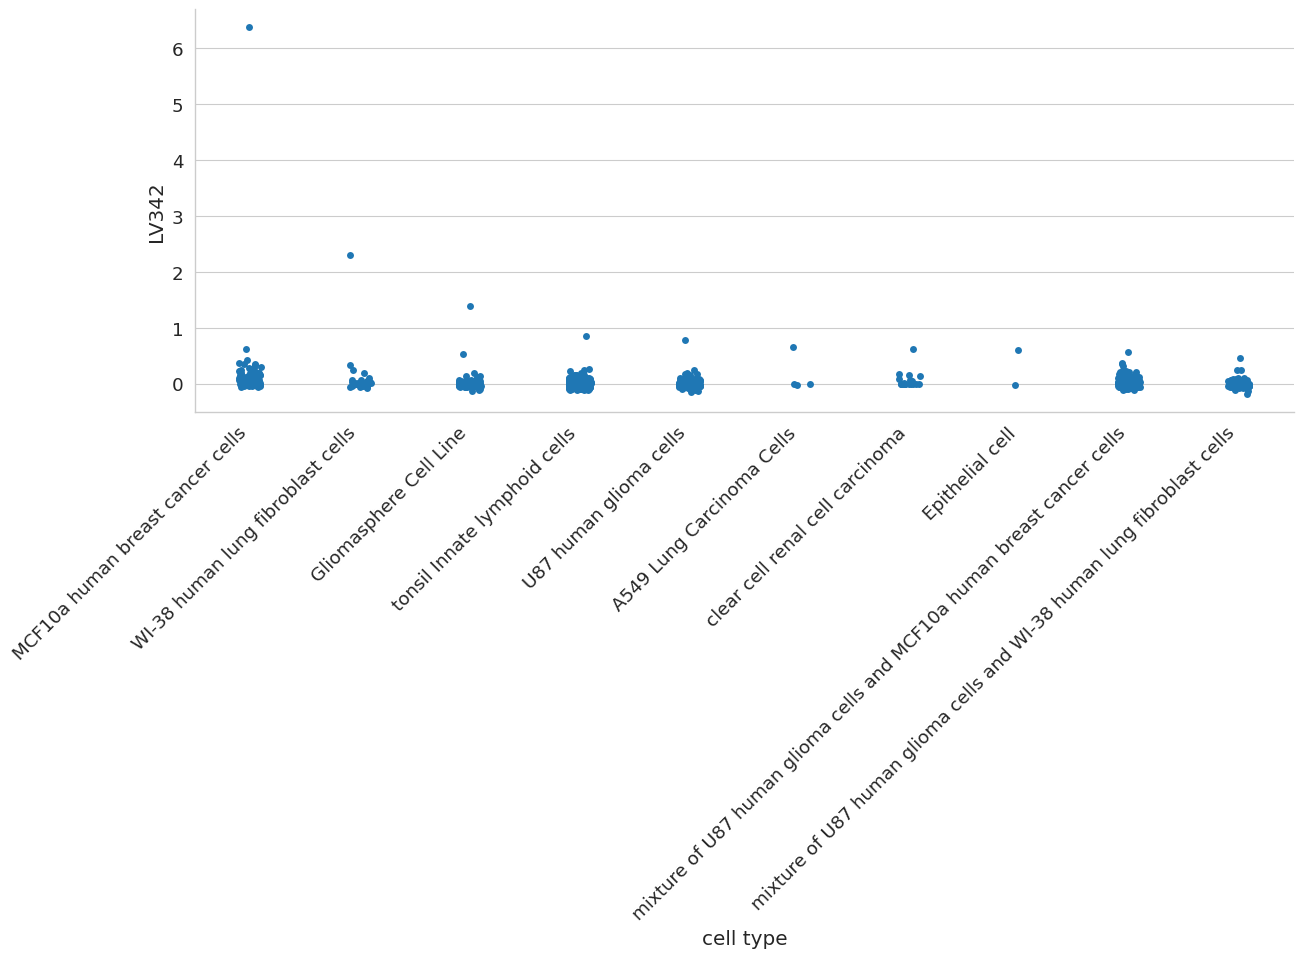

In [35]:
with sns.plotting_context("paper", font_scale=1.5), sns.axes_style("whitegrid"):
    sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTES[0],
        order=attr_order,
        kind="strip",
        height=5,
        aspect=3,
    )
    plt.xticks(rotation=45, horizontalalignment="right")

    # You can save the figure if you uncomment the code below
    # the figure will be created under ${DATA_FOLDER}/results/demo

#     plt.savefig(
#         OUTPUT_CELL_TYPE_FILEPATH,
#         bbox_inches="tight",
#         facecolor="white",
#     )

# Debug

Now that you have the figure for your LV, you can debug some things.
For example, you'll see above that some samples are "NOT CATEGORIZED".
Let's see which are those:

In [36]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[
        final_plot_data[SELECTED_ATTRIBUTES[0]].str.contains("NOT CAT")
    ]
    display(_tmp.head(20))

cell type     LV342
project   run                                  
SRP058773 SRR2042655  NOT CATEGORIZED  0.197384
SRP050499 SRR2013708  NOT CATEGORIZED  0.181619
          SRR2013732  NOT CATEGORIZED  0.141975
SRP055810 SRR2240590  NOT CATEGORIZED  0.139797
          SRR2240591  NOT CATEGORIZED  0.137764
          SRR2240593  NOT CATEGORIZED  0.137322
          SRR2240589  NOT CATEGORIZED  0.136459
          SRR2240592  NOT CATEGORIZED  0.130019
SRP032775 SRR1026874  NOT CATEGORIZED  0.127052
SRP025982 SRR1216113  NOT CATEGORIZED  0.120491
SRP050499 SRR2013703  NOT CATEGORIZED  0.111177
          SRR2013670  NOT CATEGORIZED  0.099273
SRP044668 SRR1521419  NOT CATEGORIZED  0.086216
SRP019936 SRR791065   NOT CATEGORIZED  0.080042
SRP050499 SRR2013715  NOT CATEGORIZED  0.072350
          SRR2013754  NOT CATEGORIZED  0.071901
SRP027383 SRR934927   NOT CATEGORIZED  0.071470
SRP050499 SRR2013702  NOT CATEGORIZED  0.069235
SRP058773 SRR2042626  NOT CATEGORIZED  0.064280
SRP050499 SRR2013561  NOT CATEGORIZED  0.063866

We don't have information about cell type/tissue for these.
But we can manually go to the URL showed before and check out.
For example, for `SRP015360` we can open our browser with this URL:
https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP015360, and see that the samples were taken from neutrophils.

If you need to see which information is provided by each SRP, you can again use the code below:

In [38]:
# what is there in these projects?
lv_data.loc[["SRP058773"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
).head(60)

well number reprogramming time point (day)     LV342
project   run                                                            
SRP058773 SRR2042655           5                             10  0.197384
          SRR2042626          59                             10  0.064280
          SRR2042624          20                             10  0.061749
          SRR2042650          10                             10  0.053322
          SRR2042659          50                             10  0.037316
          SRR2042656          32                             10  0.035191
          SRR2042654          66                             10  0.034986
          SRR2042631          63                             10  0.025180
          SRR2042621          39                             10  0.019054
          SRR2042657          81                             10  0.017493
          SRR2042611          34                             10  0.011828
          SRR2042633          84                             10  0.009825
          SRR2042617          40                             10  0.008439
          SRR2042644          44                             10  0.005466
          SRR2042652          31                             10  0.005330
          SRR2042618          14                             10  0.001869
          SRR2042610          41                             10  0.001652
          SRR2042642          30                             10  0.001247
          SRR2042638          26                             10  0.000641
          SRR2042612          38                             10 -0.001329
          SRR2042614          23                             10 -0.006408
          SRR2042615          90                             10 -0.010452
          SRR2042607          22                             10 -0.010836
          SRR2042640          72                             10 -0.010876
          SRR2042630          21                             10 -0.013474
          SRR2042632          58                             10 -0.016290
          SRR2042658          67                             10 -0.017253
          SRR2042635          88                             10 -0.018510
          SRR2042646          48                             10 -0.018623
          SRR2042634          16                             10 -0.019849
          SRR2042643          65                             10 -0.023427
          SRR2042647           6                             10 -0.024322
          SRR2042616          61                             10 -0.027720
          SRR2042649          73                             10 -0.028550
          SRR2042620          56                             10 -0.029165
          SRR2042628          74                             10 -0.032543
          SRR2042629          92                             10 -0.032568
          SRR2042653           9                             10 -0.034501
          SRR2042613          76                             10 -0.035015
          SRR2042619          35                             10 -0.036831
          SRR2042636          54                             10 -0.038523
          SRR2042637          45                             10 -0.038641
          SRR2042645          27                             10 -0.039439
          SRR2042648          69                             10 -0.042857
          SRR2042639          68                             10 -0.045096
          SRR2042641          11                             10 -0.045432
          SRR2042623          77                             10 -0.046336
          SRR2042625          43                             10 -0.047475
          SRR2042627          89                             10 -0.048000
          SRR2042608          91                             10 -0.051665
          SRR2042622          18                             10 -0.059206
          SRR2042609          60                             10 -0.062211

Now you can go back to section `Standardize cell type names` in this notebook and adjust according to this findings to improve the figure.
Once you are happy, you can remove the `NOT CATEGORIZED` items by uncommenting the code in `Delete samples with no tissue/cell type information`.